### Modelo de ML para predicción de precios de steam games

##### 1) Análisis EDA

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

a) Leemos el archivo limpio, trabajado en el ETL

In [3]:
df = pd.read_csv('steam_games_limpio.csv')

b) Elimino las columnas que no van a ser relevantes ni útiles para el modelo de predicción 

In [4]:
# Para el modelo de ML voy a eliminar la columna ID ya que es irrelevante para el análisis, al igual que titulos (ya que
# si quisiera categorizarla, al haber tantos titulos sería imposible), por este mismo motivo eliminaré también las columnas
# publisher y developer. La columna de release_date, para este análisis de precio será irrelevante, solo nos quedaremos con
# año por si llegaramos a necesitarla
columnas_eliminar = ["id","release_date","title","publisher","developer"]
df = df.drop(columnas_eliminar,axis=1)

c) En este paso separaré las columnas genres y specs para que quede solo un genre y un spec por registro, ya que se encuentran en forma de lista

In [5]:
# Ahora para poder categorizar bien, hare un explode de la columna genres y luego specs para poder codificarlas
df['genres'] = df['genres'].str.split(',')

In [6]:
df = df.explode('genres')

In [7]:
df.head()

,genres,specs,price,early_access,sentiment,metascore,sentiment_code,año
0,['Action',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Casual',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Indie',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Simulation',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Strategy'],['Single-player'],4.99,False,unknown,0,0.0,2018


In [8]:
# Limpiamos la columna genres de los signos de puntuación que quedaron 
df['genres'] = df['genres'].str.extract(r"'(\w+)'")

In [9]:
# Hacemos lo mismo con specs
df['specs'] = df['specs'].str.split(',')

In [10]:
df = df.explode('specs')

In [11]:
clean_spec = lambda x: x.replace("[", "").replace("]", "").replace("'", "")
# Aplicamos la función lambda a la columna 'specs'
df['specs'] = df['specs'].apply(clean_spec)

In [12]:
df['specs'] = df['specs'].str.replace('-', ' ')

In [13]:
# Reseteamos los índices para no tener inconvenientes
df = df.reset_index(drop=True)

In [14]:
df.head(20)

,genres,specs,price,early_access,sentiment,metascore,sentiment_code,año
0,Action,Single player,4.99,False,unknown,0,0.0,2018
1,Casual,Single player,4.99,False,unknown,0,0.0,2018
2,Indie,Single player,4.99,False,unknown,0,0.0,2018
3,Simulation,Single player,4.99,False,unknown,0,0.0,2018
4,Strategy,Single player,4.99,False,unknown,0,0.0,2018
5,NaN,Single player,0.00,False,Mostly Positive,0,6.0,2018
6,NaN,Multi player,0.00,False,Mostly Positive,0,6.0,2018
7,NaN,Online Multi Player,0.00,False,Mostly Positive,0,6.0,2018
8,NaN,Cross Platform Multiplayer,0.00,False,Mostly Positive,0,6.0,2018
9,NaN,Steam Achievements,0.00,False,Mostly Positive,0,6.0,2018


In [15]:
df.shape

(309581, 8)

d) Eliminamos los nuevos nan que hayan aparecido al hacer el explode

In [16]:
df.genres.unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy', nan, 'RPG',
       'Sports', 'Adventure', 'Racing', 'Education', 'Utilities',
       'Accounting'], dtype=object)

In [17]:
df.genres.isna().sum()

24784

In [18]:
# Como es necesario usar el género en nuestro modelo de ML y no podemos imputar el valor con un interpolate o técnica similar,
# ya que es una categoría, vamos a eliminar los nan, no representa un valor significativo para el conjunto de datos
df.dropna(subset=["genres"], inplace=True)

In [19]:
df.genres.unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy', 'RPG',
       'Sports', 'Adventure', 'Racing', 'Education', 'Utilities',
       'Accounting'], dtype=object)

In [20]:
df.specs.unique()
# Al parecer, hay algunos specs duplicados porque tienen un espacio adelante, para intentar reducir esta lista vamos a 
# eliminar estos espacios

array(['Single player', ' Multi player', ' Online Multi Player',
       ' Cross Platform Multiplayer', ' Steam Achievements',
       ' Steam Trading Cards', ' In App Purchases', ' Stats',
       ' Downloadable Content', ' Full controller support',
       ' Steam Cloud', ' Steam Leaderboards',
       ' Partial Controller Support', ' Local Co op',
       ' Shared/Split Screen', ' Valve Anti Cheat enabled', ' Co op',
       ' Captions available', ' Steam Workshop', ' Includes level editor',
       'Multi player', ' Mods', ' MMO', ' Online Co op',
       ' Local Multi Player', ' Includes Source SDK',
       'Downloadable Content', ' Commentary available', 'Co op',
       ' Steam Turn Notifications', 'Partial Controller Support',
       'unknown', 'MMO', 'Steam Achievements', 'Shared/Split Screen',
       'Includes level editor', 'Online Multi Player',
       'Local Multi Player', 'Captions available', 'Steam Cloud',
       'Steam Trading Cards', 'In App Purchases', 'Steam Workshop',
      

In [21]:
df['specs'] = df['specs'].str.strip()

In [22]:
df.specs.unique()
# Redució la lista significativamente

array(['Single player', 'Multi player', 'Online Multi Player',
       'Cross Platform Multiplayer', 'Steam Achievements',
       'Steam Trading Cards', 'In App Purchases', 'Stats',
       'Downloadable Content', 'Full controller support', 'Steam Cloud',
       'Steam Leaderboards', 'Partial Controller Support', 'Local Co op',
       'Shared/Split Screen', 'Valve Anti Cheat enabled', 'Co op',
       'Captions available', 'Steam Workshop', 'Includes level editor',
       'Mods', 'MMO', 'Online Co op', 'Local Multi Player',
       'Includes Source SDK', 'Commentary available',
       'Steam Turn Notifications', 'unknown', 'SteamVR Collectibles',
       'Game demo', 'Mods (require HL2)'], dtype=object)

In [23]:
df.specs.isna().sum()

0

e) Encoding de variables para convertirlas a categóricas, ya que los modelos no admiten variables str:
Primero probaremos hacer label encoding a ambas columnas (genres y specs), luego probaremos hacer dummies a la columna genres que es de nuestro mayor interes, para ver con cual obtenemos mejores resultados

In [24]:
# Ahora si aplicamos label encoding a estas dos columnas (porque si quiseramos hacer one hot encoding nos agregaría
# demasiadas columnas lo que haría el modelo muy pesado para la API)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder_specs = LabelEncoder()
label_encoder_genres = LabelEncoder()

df['specs_encoded'] = label_encoder_specs.fit_transform(df['specs'])
df['genres_encoded'] = label_encoder_genres.fit_transform(df['genres'])

In [60]:
# Guardo el label encoder de genres en un archivo pkl para poder usarlo en mi función de predicción 
import joblib
joblib.dump(label_encoder_genres, 'label_encoder.pkl') 

['label_encoder.pkl']

In [25]:
df.head()

,genres,specs,price,early_access,sentiment,metascore,sentiment_code,año,specs_encoded,genres_encoded
0,Action,Single player,4.99,False,unknown,0,0.0,2018,20,1
1,Casual,Single player,4.99,False,unknown,0,0.0,2018,20,3
2,Indie,Single player,4.99,False,unknown,0,0.0,2018,20,5
3,Simulation,Single player,4.99,False,unknown,0,0.0,2018,20,8
4,Strategy,Single player,4.99,False,unknown,0,0.0,2018,20,10


f) Seleccionamos las columnas con las que trabajaremos y hacemos nuestro análisis exploratorio: correlaciones, heatmap, diagrama de caja y bigotes, histogramas, etc

In [26]:
# Ahora ya estamos en condiciones de usar nuestras columnas numéricas y booleanas para el análisis 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284797 entries, 0 to 309580
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   genres          284797 non-null  object 
 1   specs           284797 non-null  object 
 2   price           284797 non-null  float64
 3   early_access    284797 non-null  bool   
 4   sentiment       284797 non-null  object 
 5   metascore       284797 non-null  int64  
 6   sentiment_code  284756 non-null  float64
 7   año             284797 non-null  int64  
 8   specs_encoded   284797 non-null  int32  
 9   genres_encoded  284797 non-null  int32  
dtypes: bool(1), float64(2), int32(2), int64(2), object(3)
memory usage: 19.8+ MB


In [27]:
columnas = ["early_access","genres_encoded","specs_encoded","sentiment_code","metascore","año","price"]
df_filtrado = df[columnas]
df_filtrado.head()

,early_access,genres_encoded,specs_encoded,sentiment_code,metascore,año,price
0,False,1,20,0.0,0,2018,4.99
1,False,3,20,0.0,0,2018,4.99
2,False,5,20,0.0,0,2018,4.99
3,False,8,20,0.0,0,2018,4.99
4,False,10,20,0.0,0,2018,4.99


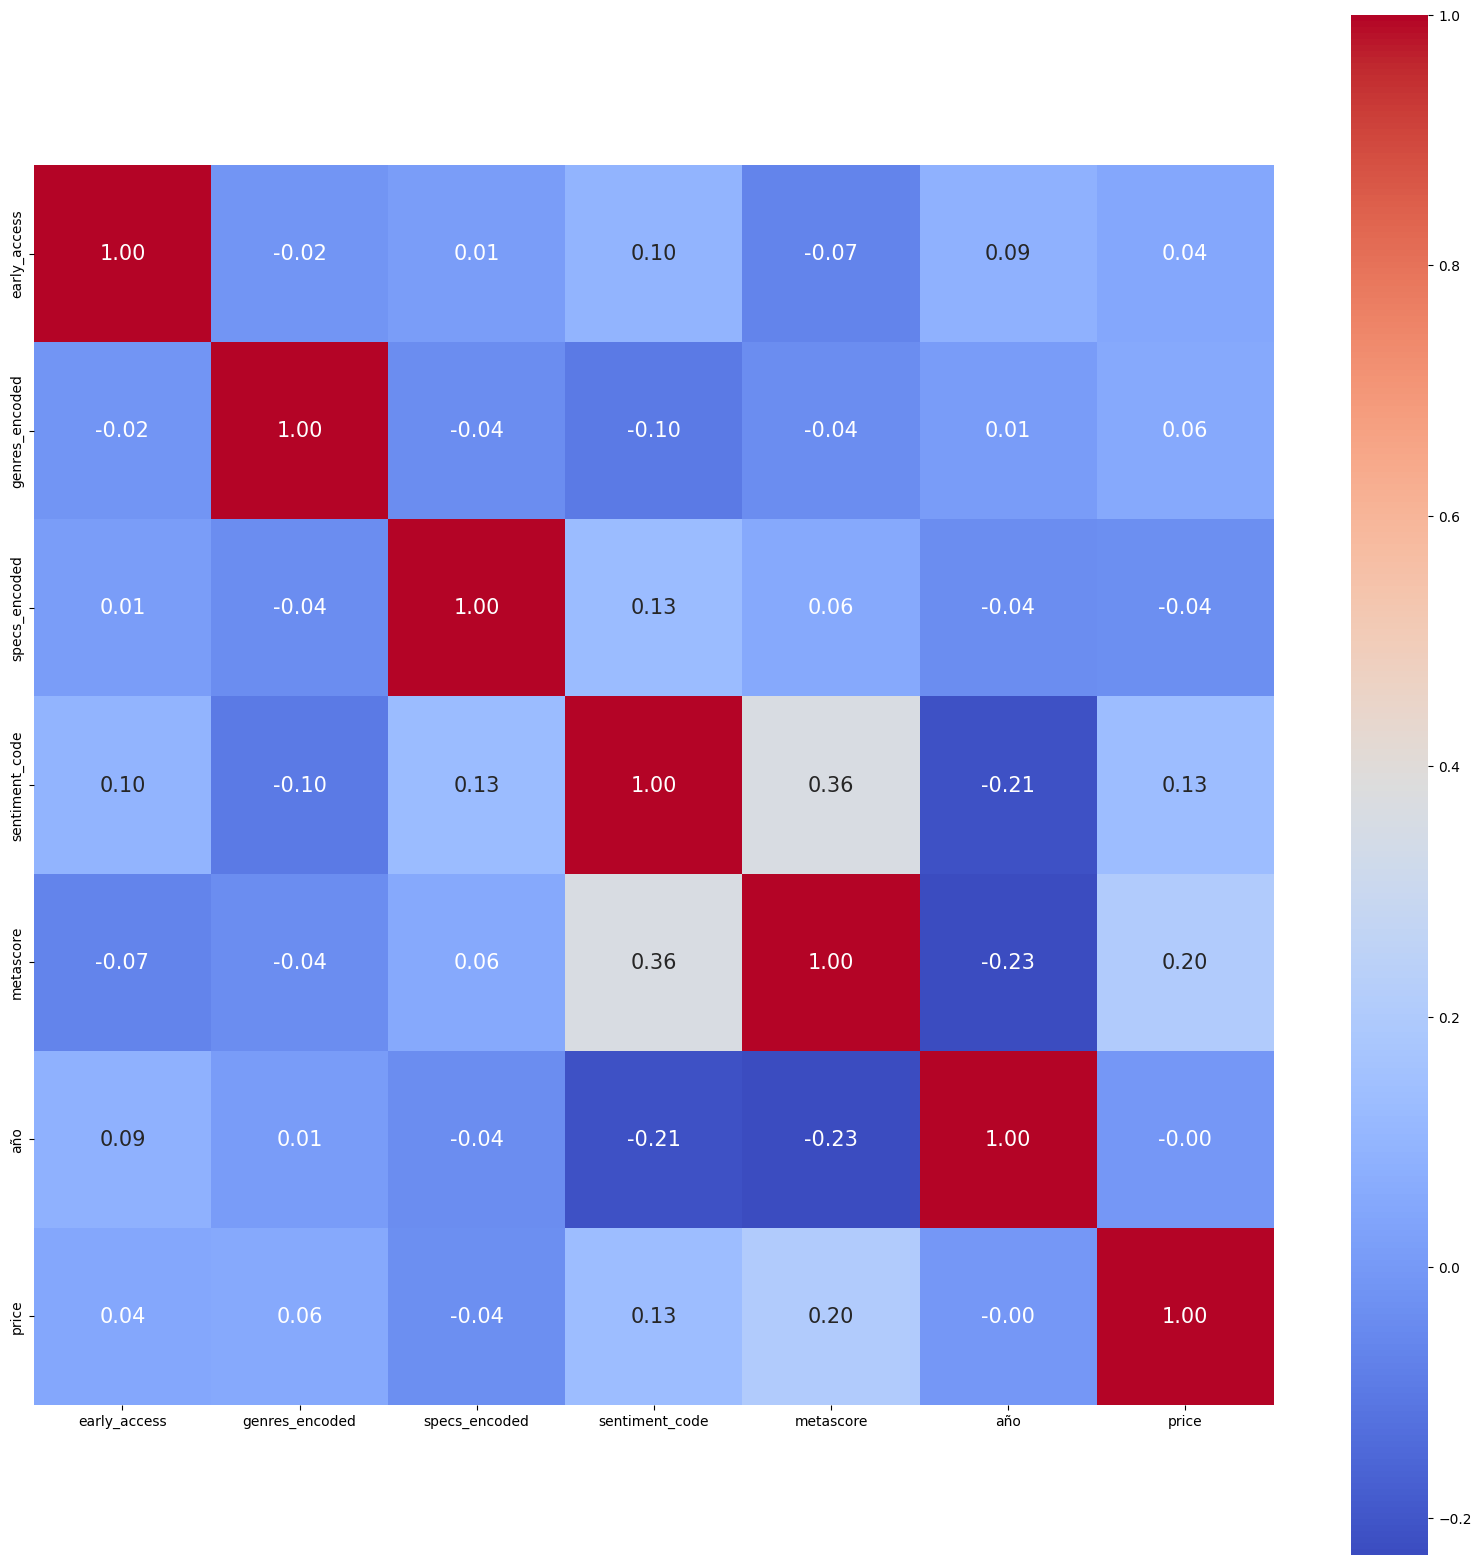

In [28]:
# Al parecer no hay nada que indique correlaciones, seguiremos indagando
corr = df_filtrado.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_filtrado.columns,
           yticklabels= df_filtrado.columns,
           cmap= 'coolwarm')
plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


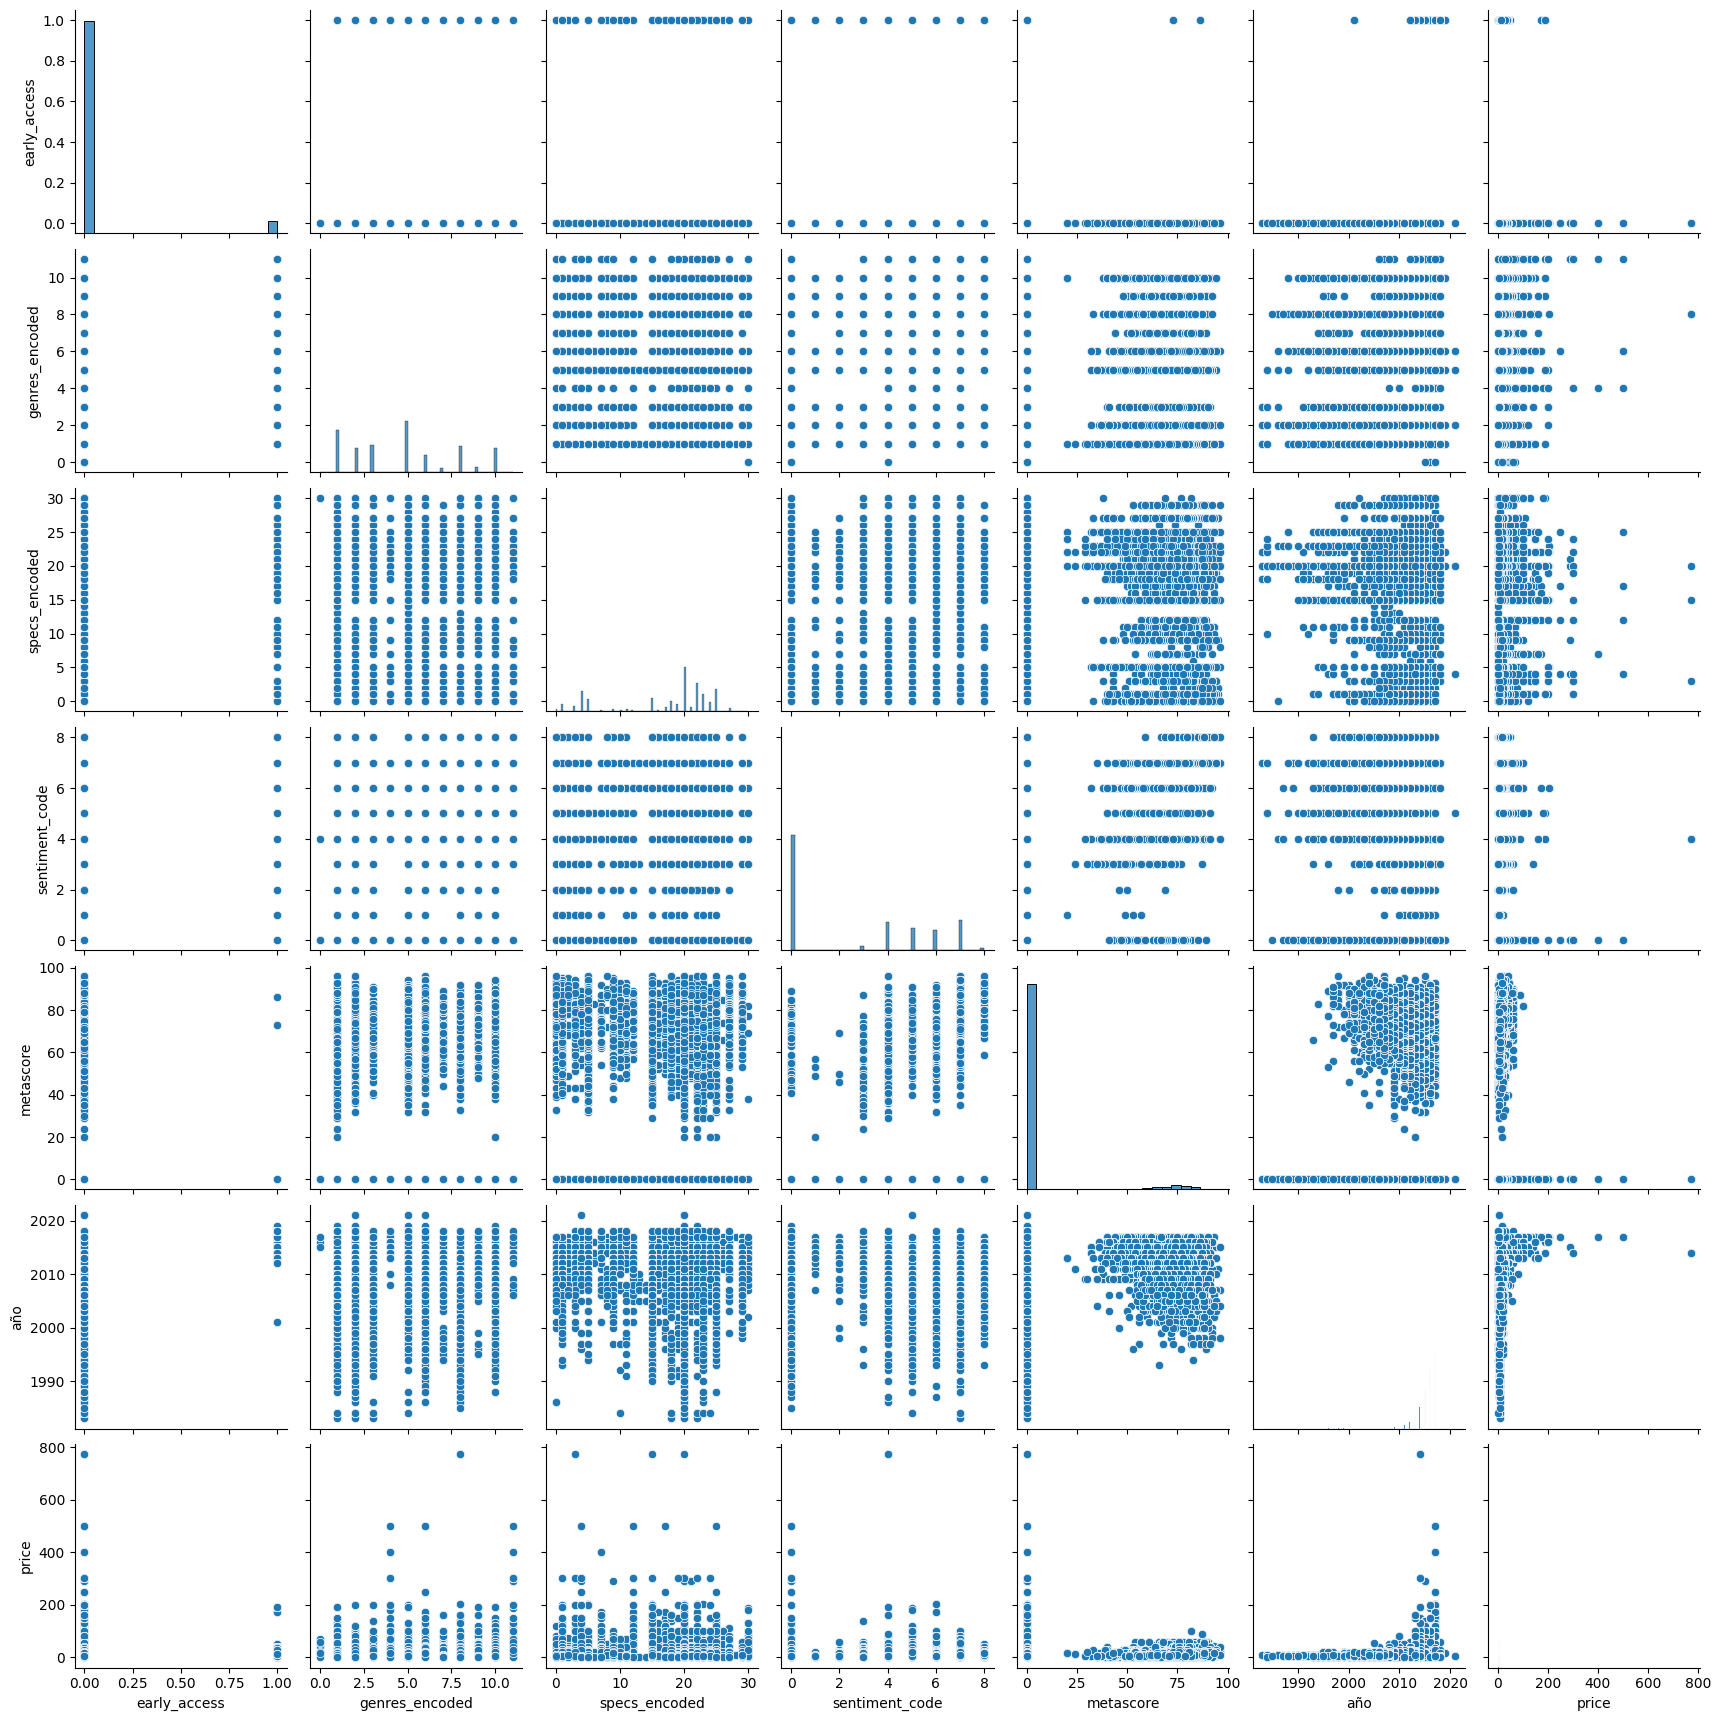

In [52]:
sns.pairplot(data=df_filtrado)
plt.show()
# Vemos que el gráfico no se aprecia muy bien debido a los outliers

In [29]:
# Vemos algunos outliers en precio
outliers100 = (df['price'] > 100).sum()
outliers50 = (df['price'] > 50).sum()
print(outliers50, "el porcentaje sobre los datos totales de los outliers >50 es", (outliers50/df.shape[0])*100,"%")
print(outliers100, "el porcentaje sobre los datos totales de los outliers >100 es", (outliers100/df.shape[0])*100,"%")
print("Nos quedaremos con los precios entre 0 y 100")
# Al ser una cantidad insignificante para el número de datos que tenemos, y viendo que la mayor cantidad de datos se
# de concentra entre 0 y 100, vamos a proceder a elimnarlos y quedarnos con lo que nos interesa para volver a hacer 
# el pairplot y heatmap

2279 el porcentaje sobre los datos totales de los outliers >50 es 0.8002191034315671 %
266 el porcentaje sobre los datos totales de los outliers >100 es 0.09339986025133692 %
Nos quedaremos con los precios entre 0 y 100


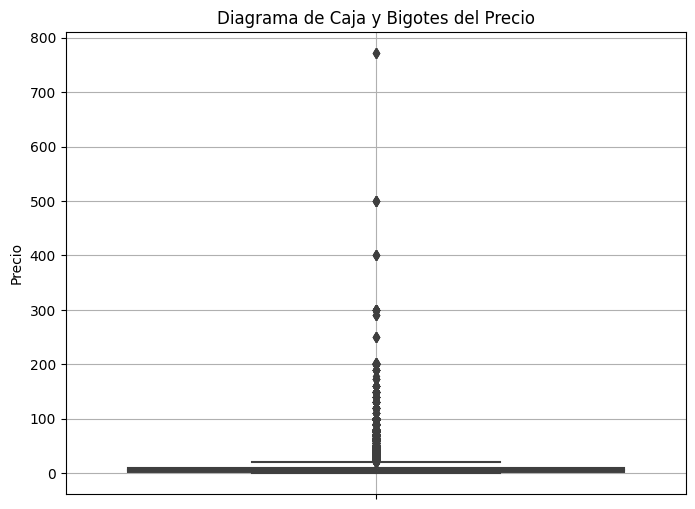

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtrado, y='price')
plt.title('Diagrama de Caja y Bigotes del Precio')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

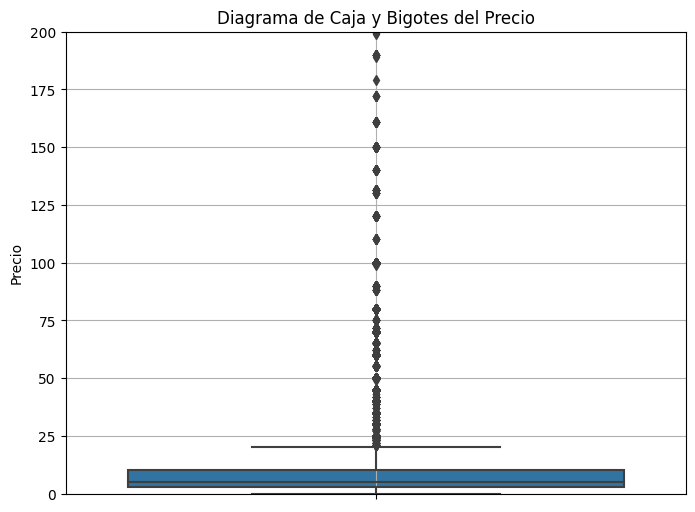

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtrado, y='price')
plt.title('Diagrama de Caja y Bigotes del Precio')
plt.ylim(0, 200)  # Establecemos los límites en el eje y entre 0 y 200 porque hay muy pocos valores por fuera
plt.ylabel('Precio')
plt.grid(True)
plt.show()


In [32]:
#Filtramos el df para los precios 
df_limpio = df_filtrado[df_filtrado['price'] <= 100]

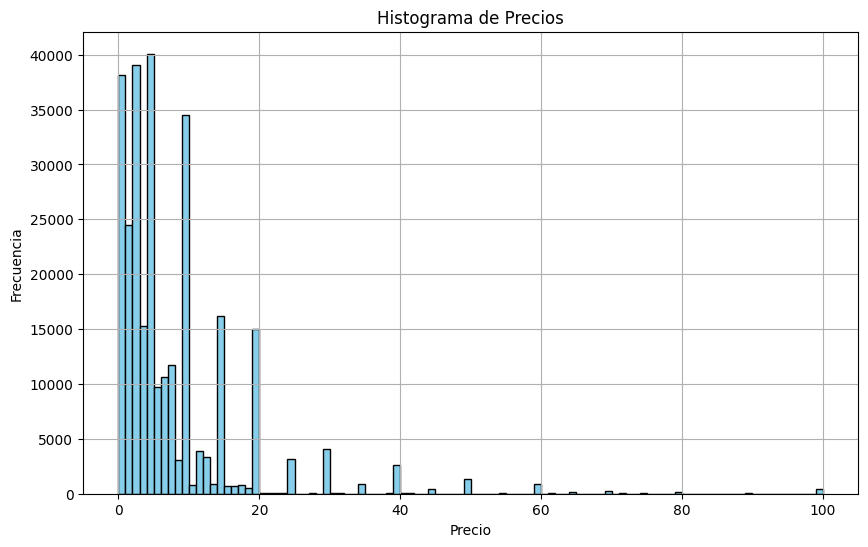

In [33]:
plt.figure(figsize=(10, 6))

plt.hist(df_limpio['price'], bins=100, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.title('Histograma de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)

In [34]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284531 entries, 0 to 309580
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   early_access    284531 non-null  bool   
 1   genres_encoded  284531 non-null  int32  
 2   specs_encoded   284531 non-null  int32  
 3   sentiment_code  284490 non-null  float64
 4   metascore       284531 non-null  int64  
 5   año             284531 non-null  int64  
 6   price           284531 non-null  float64
dtypes: bool(1), float64(2), int32(2), int64(2)
memory usage: 13.3 MB


Rehacemos el pairplot y heatmap pero solo teniendo en cuenta los precios menores o iguales a 100

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


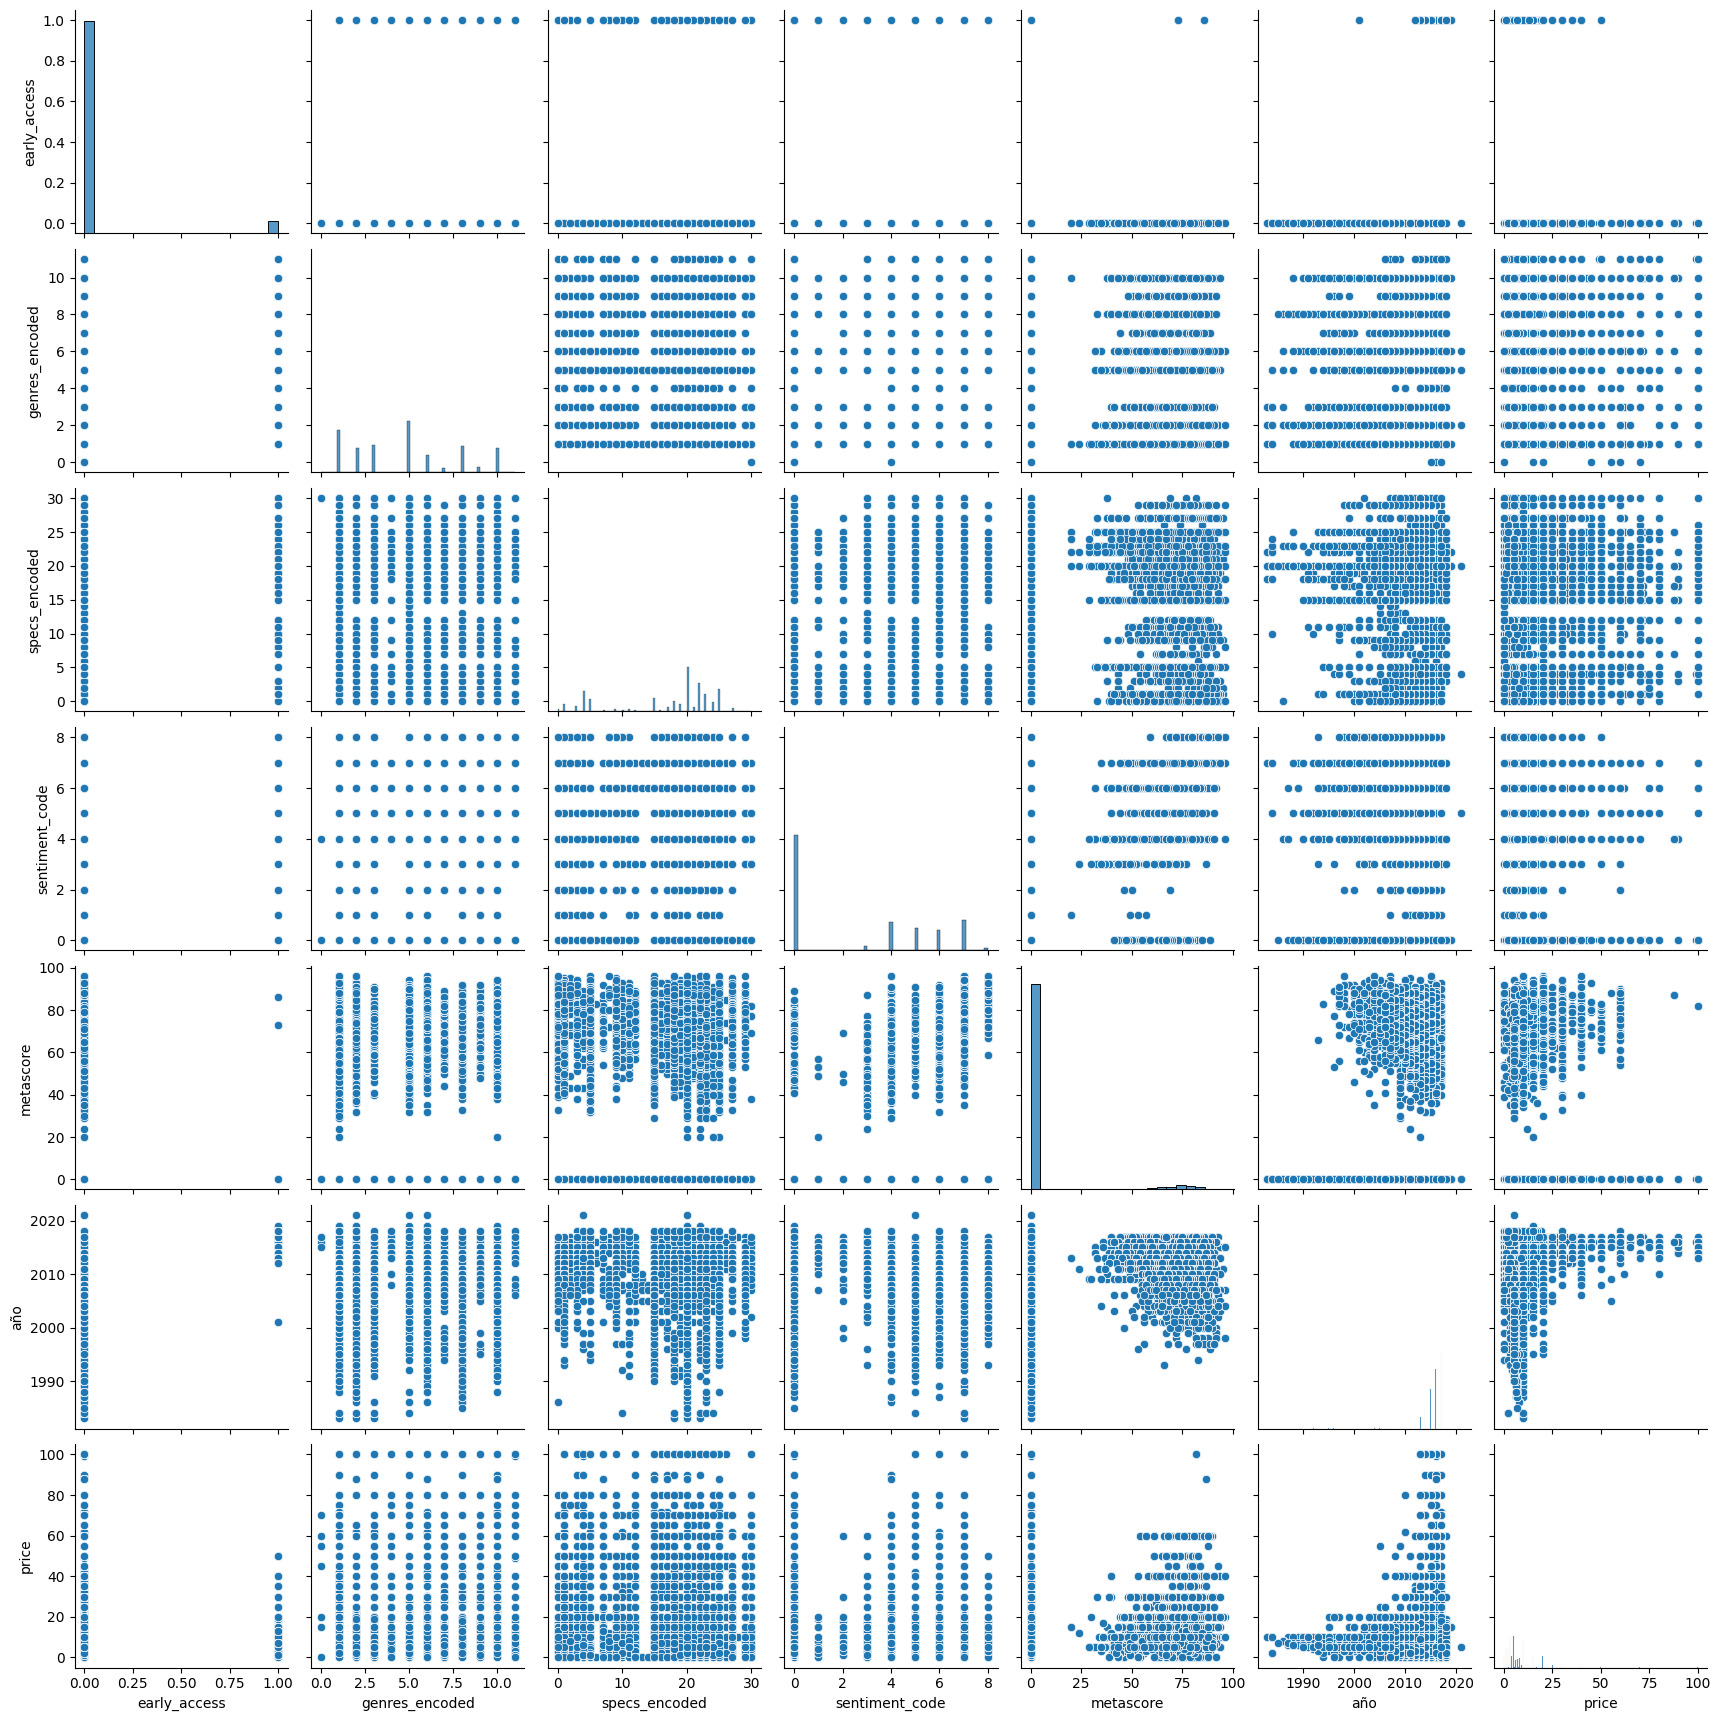

In [481]:
sns.pairplot(data=df_limpio)
plt.show()

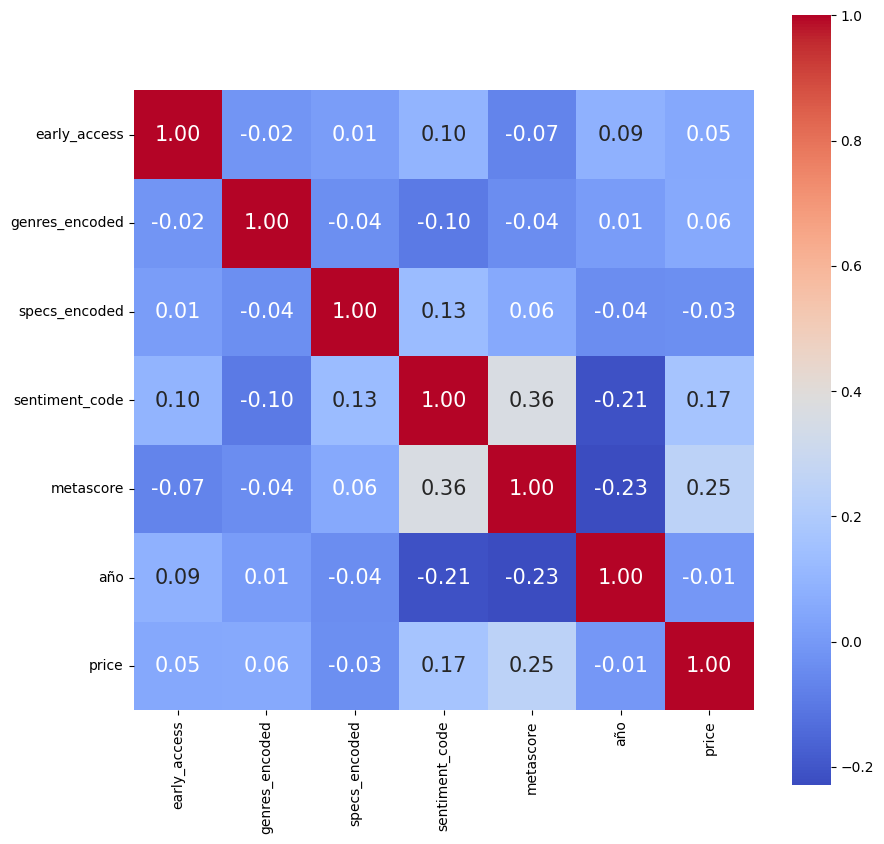

In [35]:
corr = df_limpio.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_limpio.columns,
           yticklabels= df_limpio.columns,
           cmap= 'coolwarm')
plt.show()

g) Manejo de nans de metascore y sentiment_code

In [36]:
# En el ETL imputamos el valor cero a los datos de metascore vacios, y 0.0 a sentiment_code en los cuales el registro era
# nan, si bien podemos asumir que los juegos sin metascore su puntaje es cero, intuitivamente podemos pensar que en general
# cuando las personas tienen una mala experiencia es cuando más dejan sus reviews, y cuando están satisfechas no hacen
# comentarios (generalmente), por lo que no sería correcto imputarle valor cero a los datos vacíos, por esto los eliminaremos
df_metascore0 = df_limpio[df_limpio["metascore"]==0]
df_sentiment0 = df_limpio[df_limpio["sentiment_code"]==0.0]
num_registros_metascore0 = df_metascore0.shape[0]
num_registros_sentiment0 = df_sentiment0.shape[0]
print("los nan de metascore son:",num_registros_metascore0, "y los nan de sentiment son:", num_registros_sentiment0)

los nan de metascore son: 259955 y los nan de sentiment son: 145363


In [37]:
indices_a_eliminar = df_limpio[df_limpio["metascore"]==0].index.union(df_limpio[df_limpio["sentiment_code"]==0.0].index)
df_sin_nans = df_limpio.drop(indices_a_eliminar)

In [38]:
df_sin_nans.shape

(23799, 7)

Rehacemos nuevamente el heat map y matriz de correlación para ver que resultados obtenemos con este nuevo filtro de datos

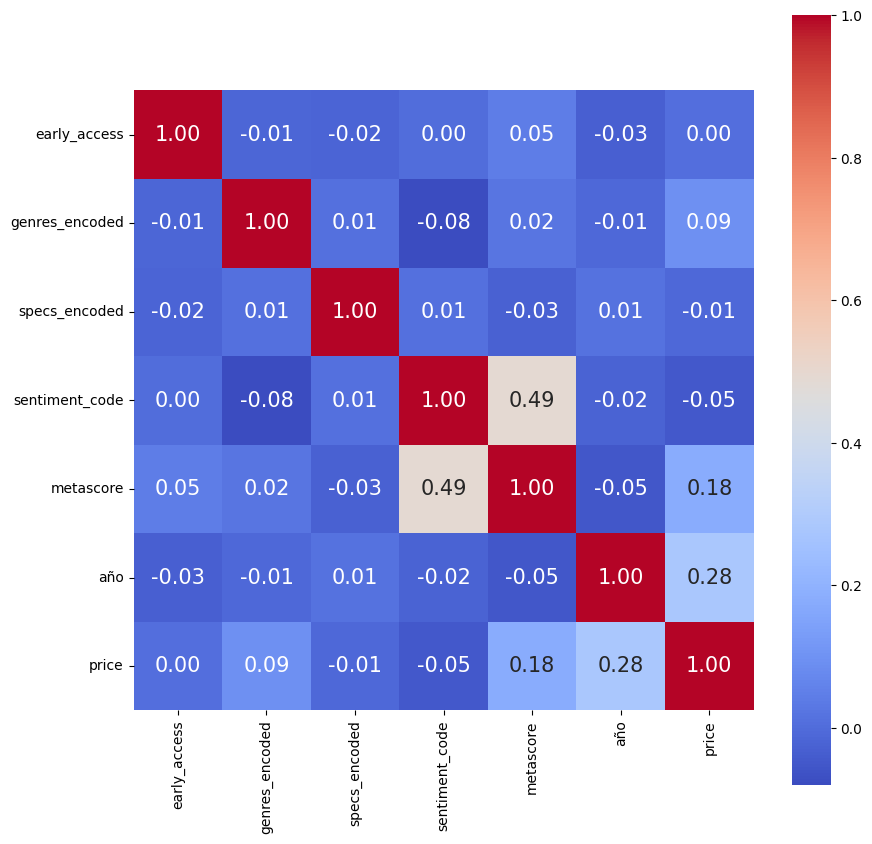

In [39]:
corr = df_sin_nans.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_sin_nans.columns,
           yticklabels= df_sin_nans.columns,
           cmap= 'coolwarm')
plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


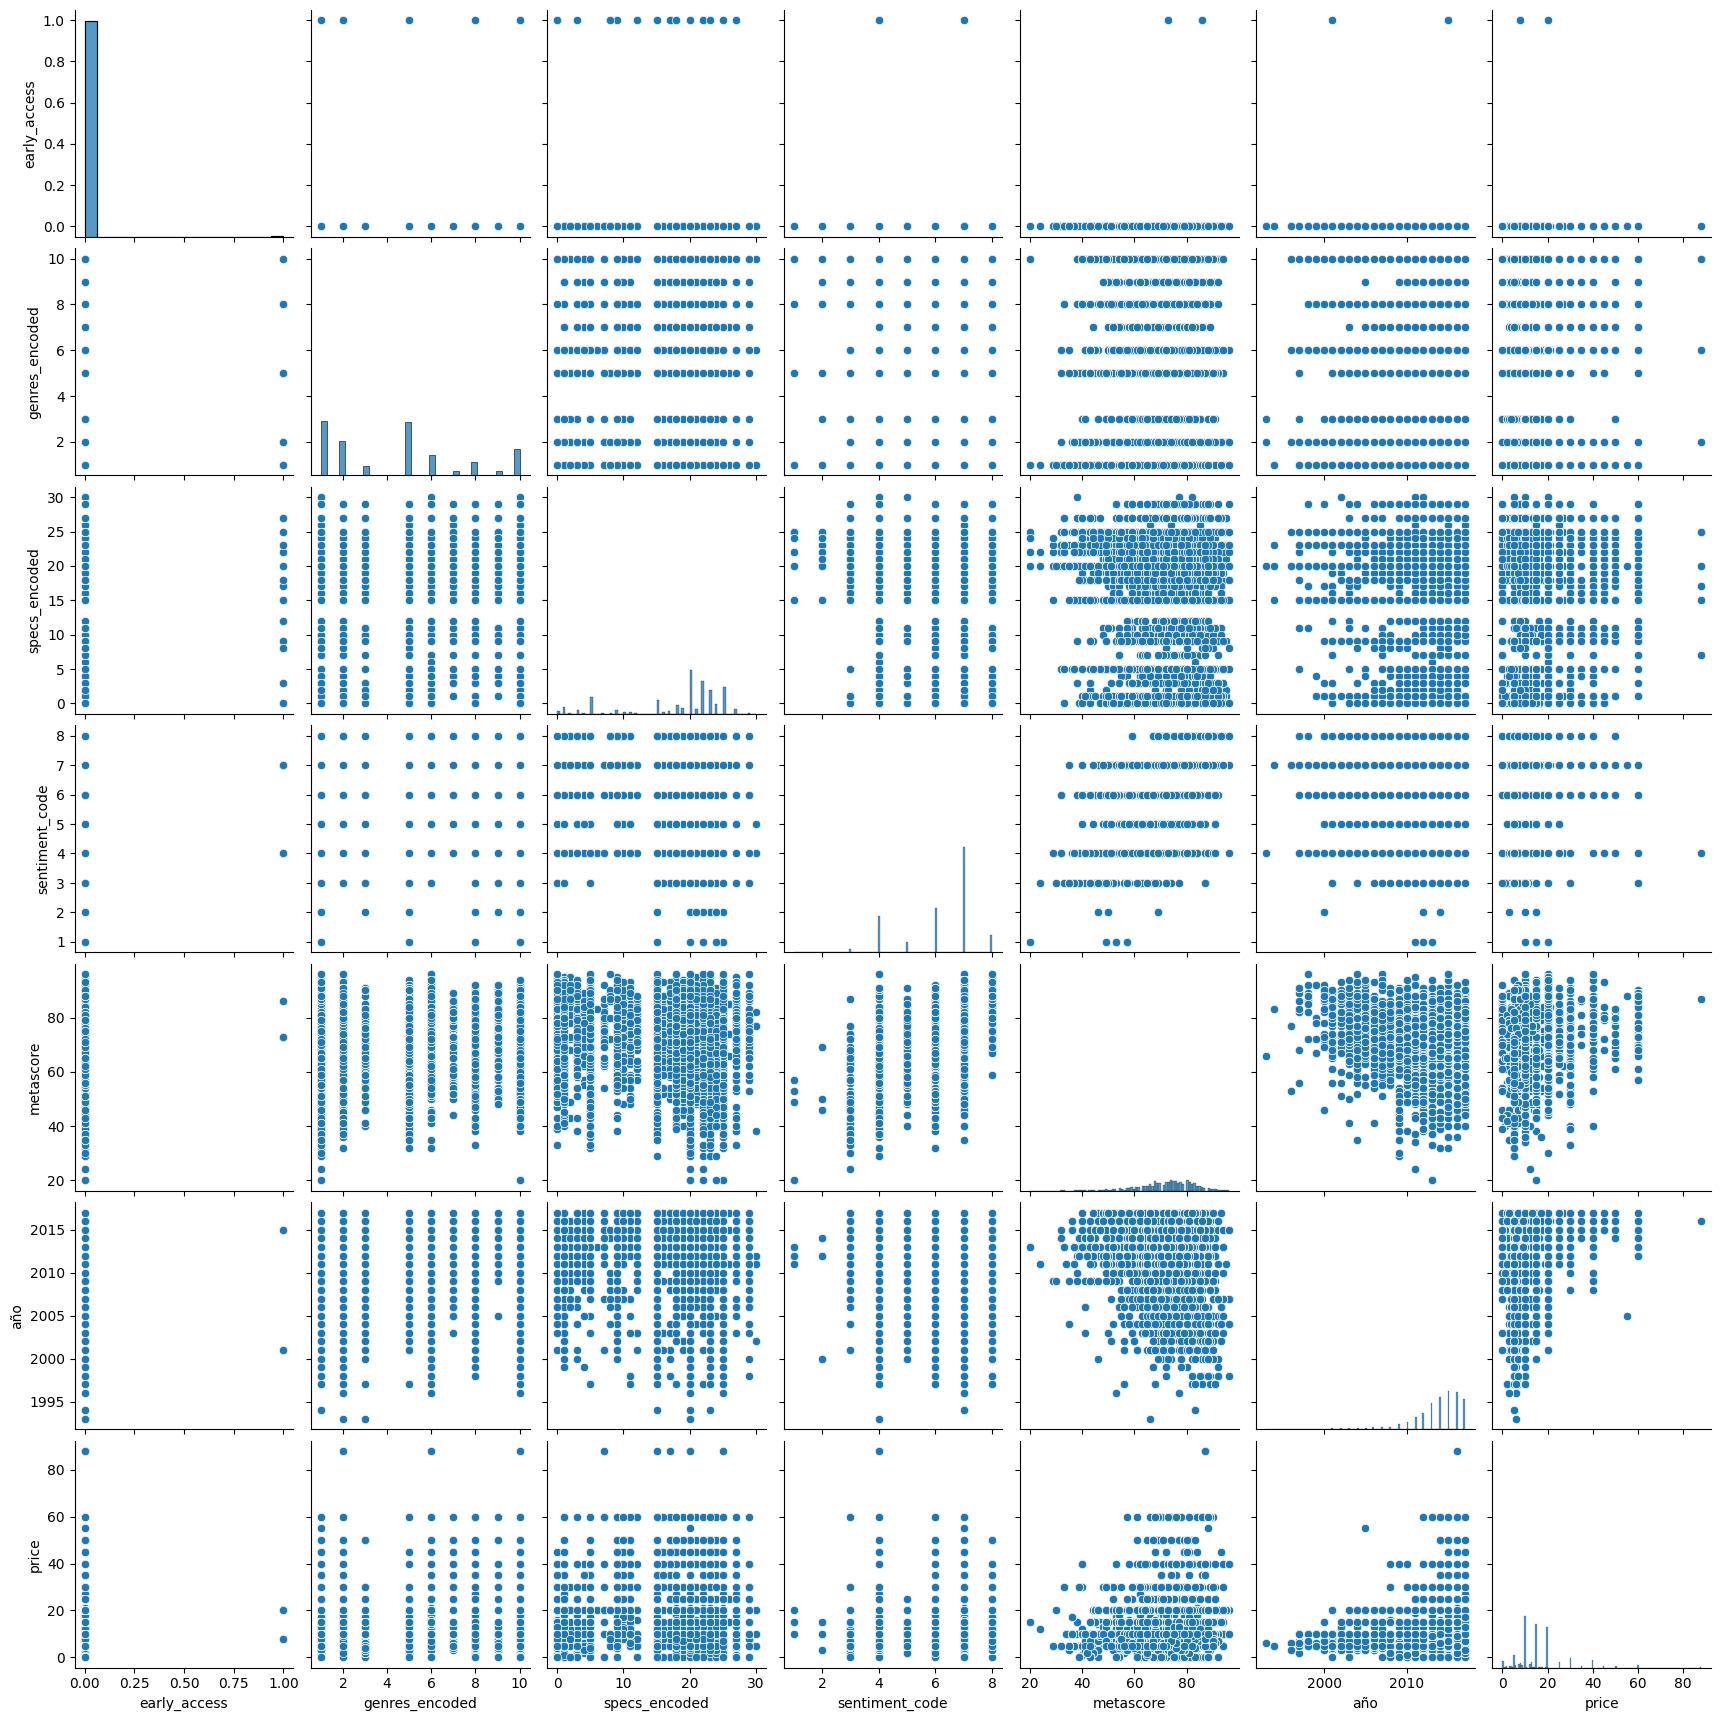

In [63]:
sns.pairplot(data=df_sin_nans)
plt.show()

- En primer lugar se observa que metascore está relacionado con sentiment_code, por lo tanto nos quedaremos solo con metascore (además que hacer un análisis de sentimiento implica un análisis más profundo)

- En segundo lugar podemos notar que specs no tiene correlación con el precio, podría hacerse un análisis más profundo con dummies, pero implicaría un alto costo computacional debido a la cantidad de variantes en specs

- En tercer lugar, se ve que early access está desbalanceada, intuitivamente podemos pensar que esta variable podría estar relacionada con el precio por lo que vamos a intentar hacer un sobremuestreo para balancearla.

In [40]:
df_sin_nans["early_access"].value_counts()

early_access
False    23751
True        48
Name: count, dtype: int64

In [41]:
# Contar la cantidad de muestras en cada clase
counts = df_sin_nans['early_access'].value_counts()

# Obtener el tamaño de la clase mayoritaria (False)
majority_class_size = counts[False]

# Obtener todas las muestras de la clase minoritaria (True)
df_minority = df_sin_nans[df_sin_nans['early_access'] == True]

# Hacer un sobremuestreo replicando las muestras de la clase minoritaria
df_oversampled = df_minority.sample(majority_class_size, replace=True, random_state=42)

# Combinar ambos DataFrames para obtener el sobremuestreo final
df_balanced = pd.concat([df_sin_nans[df_sin_nans['early_access'] == False], df_oversampled])

# Verificar el balance en la columna 'early_access'
print(df_balanced['early_access'].value_counts())


early_access
False    23751
True     23751
Name: count, dtype: int64


In [42]:
eliminar = ["sentiment_code", "specs_encoded"]
df_balanced = df_balanced.drop(eliminar,axis=1)

In [43]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47502 entries, 388 to 263529
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   early_access    47502 non-null  bool   
 1   genres_encoded  47502 non-null  int32  
 2   metascore       47502 non-null  int64  
 3   año             47502 non-null  int64  
 4   price           47502 non-null  float64
dtypes: bool(1), float64(1), int32(1), int64(2)
memory usage: 1.7 MB


Rehacemos la matriz de correlación y el heatmap para ver los resultados del sobremuestreo

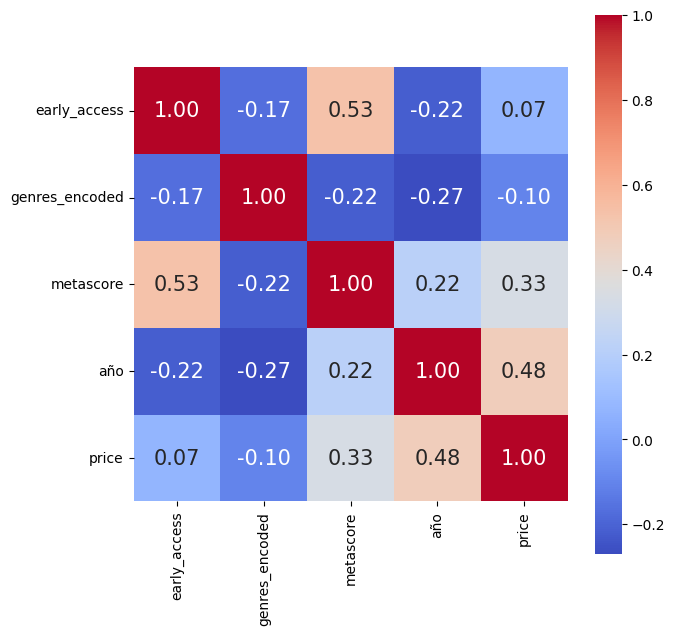

In [44]:
corr = df_balanced.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_balanced.columns,
           yticklabels= df_balanced.columns,
           cmap= 'coolwarm')
plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


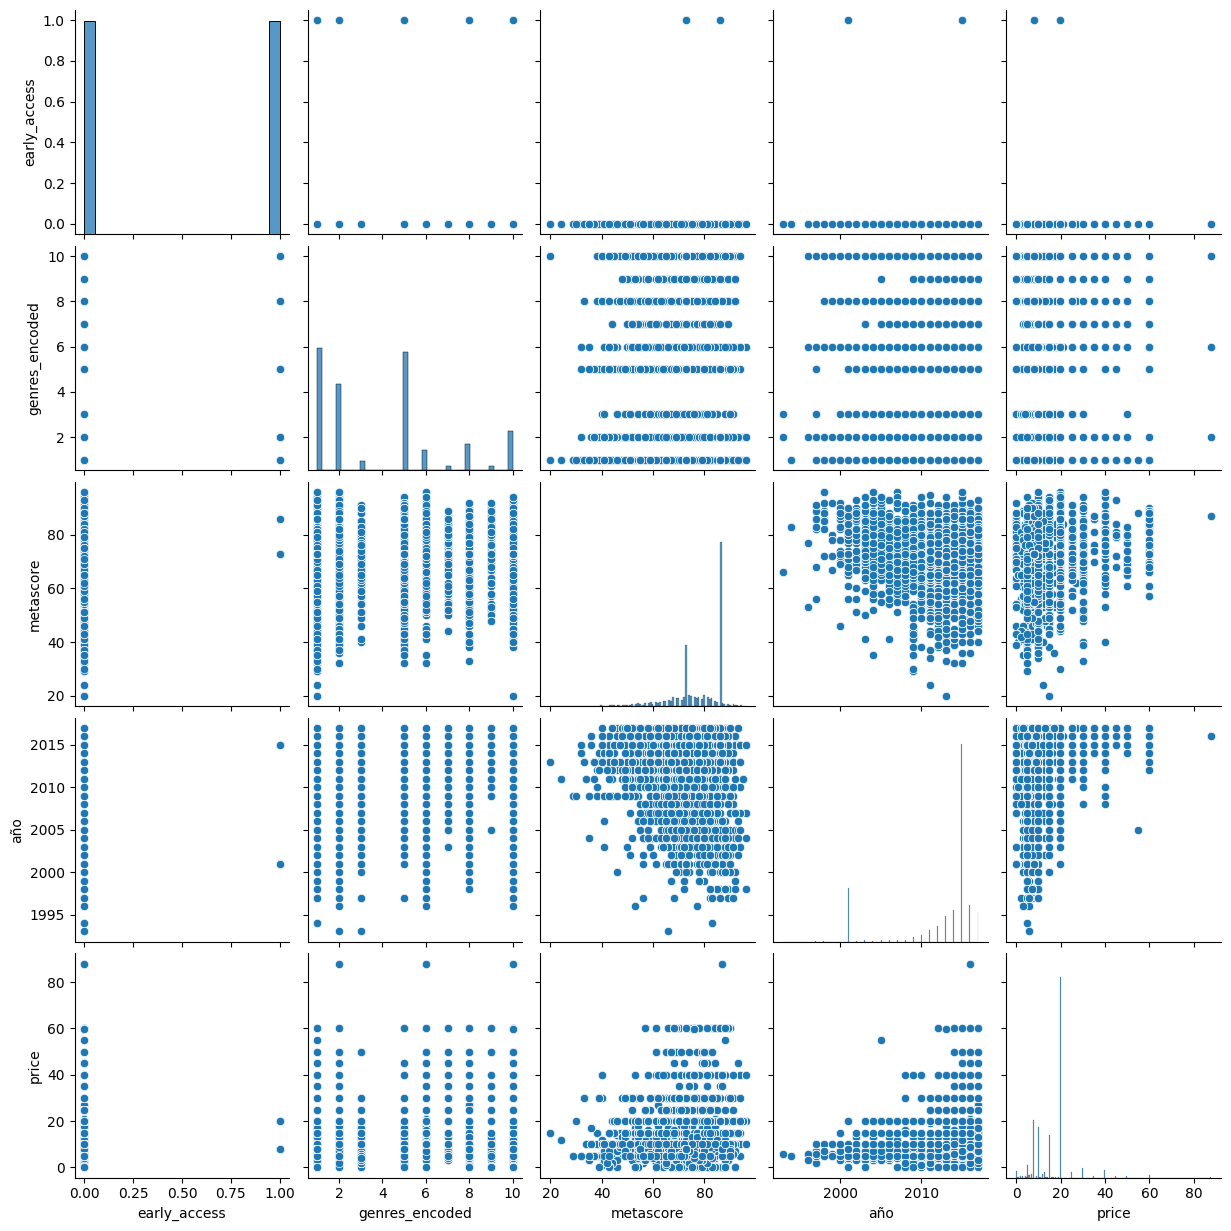

In [523]:
sns.pairplot(data=df_balanced)
plt.show()

In [47]:
# Guardamos el df que se usará para entrenar el modelo 
df_balanced.to_csv('df_modelo_entrenado.csv', index=False)

##### 2) Comenzamos con los modelos de predicción con las variables que tenemos, si bien hay un poco de correlación entre metascore y early_access, luego determinaremos con feature_importances con cual quedarnos para hacer más simple el modelo

a- Regresión lineal múltiple

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [49]:
feature_cols = ["early_access","genres_encoded","metascore","año"]
X = df_balanced[feature_cols]
y = df_balanced["price"]

x1 = X[["early_access"]]
x2 = X[["genres_encoded"]]
x3 = X[["metascore"]]
x4 = X[["año"]]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) #chequear que quede de la forma (n,3) (n,) (n_test,3) (n,)


(47502, 4) (47502,)
(38001, 4) (38001,) (9501, 4) (9501,)


In [50]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)
rmse_train = (mean_squared_error(y_train, y_train_pred, squared = False))
rmse_test = (mean_squared_error(y_test, y_test_pred, squared = False))
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.28787523531539494
Raíz del error cuadrático medio en Train (RMSE): 7.088857004731054
Raíz del error cuadrático medio en Test (RMSE): 6.906165790422715


b- Arbol de regresión

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del regresor "R2" es: 0.6669727014563971
Raíz del error cuadrático medio en Train (RMSE): 4.847726264957161
Raíz del error cuadrático medio en Test (RMSE): 5.017685974237884


- Probamos hacer el mismo modelo, pero con los datos de early_access sin balancear

In [571]:
feature_cols = ["early_access","genres_encoded","metascore","año"]
X = df_sin_nans[feature_cols]
y = df_sin_nans["price"]

x1 = X[["early_access"]]
x2 = X[["genres_encoded"]]
x3 = X[["metascore"]]
x4 = X[["año"]]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) #chequear que quede de la forma (n,3) (n,) (n_test,3) (n,)


(23799, 4) (23799,)
(19039, 4) (19039,) (4760, 4) (4760,)


In [572]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.5862237049594623
Raíz del error cuadrático medio en Train (RMSE): 6.8505674000123715
Raíz del error cuadrático medio en Test (RMSE): 7.097117270816156


c- Random forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=20 ,random_state=42)

rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)


r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del random forest regressor "R2" es: 0.6658793196215794
Raíz del error cuadrático medio en Train (RMSE): 4.8556776738364285
Raíz del error cuadrático medio en Test (RMSE): 5.0173280294665465


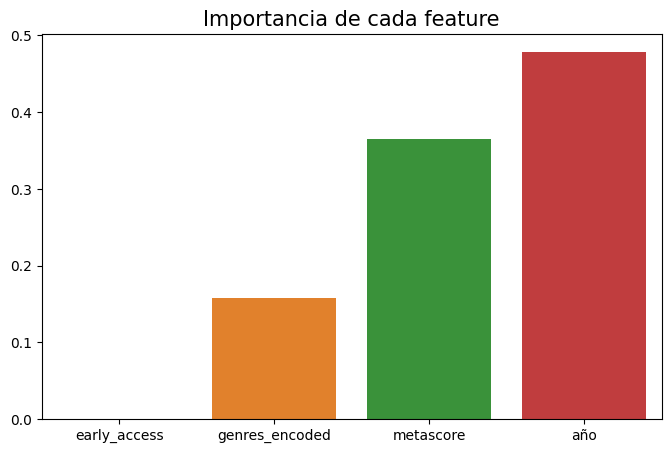

In [53]:
# Feature importances
plt.figure(figsize = (8,5))
importances = rf_regressor.feature_importances_
columns = X.columns
sns.barplot(x = columns, y = importances)
plt.title('Importancia de cada feature', fontsize = 15)
plt.show()

d- GradientBoostingRegressor

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_regressor.fit(X_train, y_train)

y_test_pred = gb_regressor.predict(X_test)
y_train_pred = gb_regressor.predict(X_train)


r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del random forest regressor "R2" es: 0.4241885880325873
Raíz del error cuadrático medio en Train (RMSE): 6.374385219344193
Raíz del error cuadrático medio en Test (RMSE): 6.307711179307794


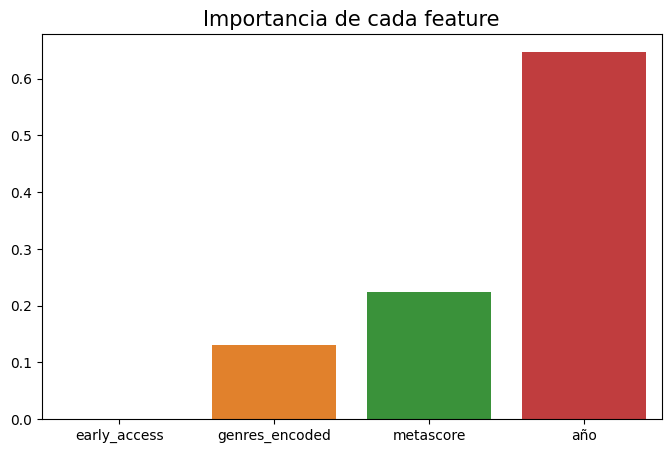

In [55]:
# IMPORTANCIA DE FEATURES EN LA PREDICCIÓN
plt.figure(figsize = (8,5))
importances = gb_regressor.feature_importances_
columns = X.columns
sns.barplot(x = columns, y = importances)
plt.title('Importancia de cada feature', fontsize = 15)
plt.show()

Luego de hacer la prueba con los diferentes modelos, vemos que tree_regresor y random forest nos dan buenos resultados, vamos a intentar mejorar el performance con un grid search en el modelo de random forest y tree regressor

In [560]:
from sklearn.model_selection import GridSearchCV

# Defino la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creo el modelo RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Creo un objeto GridSearchCV con el modelo y la cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1)

# Realizo la búsqueda de hiperparámetros con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo con los hiperparámetros encontrados
best_rf_regressor = grid_search.best_estimator_

# Realizo predicciones con el mejor modelo
y_train_pred = best_rf_regressor.predict(X_train)
y_test_pred = best_rf_regressor.predict(X_test)

# Calculamos las métricas de rendimiento de este mejor modelo
r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del random forest regressor "R2" es: 0.6660521729071712
Raíz del error cuadrático medio en Train (RMSE): 4.854421498343456
Raíz del error cuadrático medio en Test (RMSE): 5.016880961518425


In [562]:
# Obtener los mejores hiperparámetros y el mejor modelo para RandomForestRegressor
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_
print(best_params_rf)
print(best_model_rf)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Defino la cuadrícula de hiperparámetros
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creo el modelo DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)

# Creo un objeto GridSearchCV con el modelo y la cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Realizo la búsqueda de hiperparámetros con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo con los hiperparámetros encontrados
best_dt_regressor = grid_search.best_estimator_

# Realizo predicciones con el mejor modelo
y_train_pred = best_dt_regressor.predict(X_train)
y_test_pred = best_dt_regressor.predict(X_test)

# Calculamos las métricas de rendimiento de este mejor modelo
r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del decision tree regressor "R2" es:', r2)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del decision tree regressor "R2" es: 0.6669280805099909
Raíz del error cuadrático medio en Train (RMSE): 4.848051017446923
Raíz del error cuadrático medio en Test (RMSE): 5.017411031798867


In [58]:
# Obtener los mejores hiperparámetros y el mejor modelo para RandomForestRegressor
best_params_tree = grid_search.best_params_
best_model_tree = grid_search.best_estimator_
print(best_params_tree)
print(best_model_tree)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeRegressor(max_depth=20, random_state=42)


##### 3) Volvemos a realizar todo el proceso pero desde otro enfoque, transformaremos genres con get_dummies para así tener los géneros en distintas columnas y podes determinar cuales influyen y cuales no. Eliminaremos del df original los nan de early_acces ya que es una variable de interés y no podemos imputarle los valores. Luego eliminaremos la columna de genre"unknown" porque eran los genres nan en el dataframe original. Por último analizaremos si hace falta un balanceo de los datos de early_acces para poder realizar los modelos de predicción.

In [ ]:
# Continua en archivo Análisis EDA y ML 2.ipynb